# Import libraries

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
# Importing libraries
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import libraries for listing countries
#import pycountry
#import pycountry_convert as pc

# Import aux libraries
from collections import Counter
import re
#from wordcloud import WordCloud

# Import libraries for Spacy
import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher 


In [137]:
# Import tools for clustering
import umap.umap_ as umap
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import PartOfSpeech
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

In [4]:
# Check CUDA on torch
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is properly installed
print(torch.cuda.current_device())  # Returns the index of the current CUDA device
print(torch.cuda.get_device_name(torch.cuda.current_device())) 

True
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
# Import transformers and others
from transformers import pipeline
from sentence_transformers import SentenceTransformer, SimilarityFunction, util
from transformers import AutoTokenizer

In [6]:
# Import sk
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# Import own libraries
from extract_info import extract_abstracts_bib

In [8]:
%aimport extract_info

# Import information

## Load the data extracted

In [127]:
# Create the excel file with the abstracts information
bib_directory   = '00_bibFiles'
bib_file        = 'search_003'
path_export     = extract_abstracts_bib(bib_file, bib_directory,'out')

The bib file search_003 was exported successfully with 7794 entries.


In [9]:
# From the extracted information, create a dataframe
bib_file        = 'search_003'
path_export_file = os.path.join('out', bib_file+'_export.xlsx')
df_base = pd.read_excel(path_export_file)
print(df_base.columns)
print(df_base.shape)

Index(['author', 'title', 'year', 'journal', 'url', 'doi', 'abstract',
       'author_keywords', 'keywords', 'type', 'publication_stage', 'source',
       'note'],
      dtype='object')
(7794, 13)


## Data preprocess

In [18]:
# Create a new data frame with the abstracts and titles
df_analyze = df_base[['title', 'abstract']].copy()

nlp = spacy.load("en_core_web_sm")

def preprocessing_text(text):
    
    doc = nlp(text)
    # Filter out stopwords, punctuation, and currency symbols
    lemmatized_text = [
        token.lemma_.lower().strip() 
        for token in doc 
        if not token.is_stop and not token.is_punct and not token.is_currency
    ]
    
    # Further filter out tokens that are empty strings or just whitespace
    lemmatized_text = [token for token in lemmatized_text if token]
    lemmatized_text = ' '.join(lemmatized_text)
    
    return lemmatized_text

# Apply the preprocessing function to the abstracts
df_analyze['abstract_preprocess'] = df_analyze['abstract'].apply(preprocessing_text)

In [11]:
# Look for acronyms in the abstracts for standarization
def find_acronyms(text):
    return re.findall(r'\b[A-Z]{2,}\b', text)

df_analyze['acronyms'] = df_analyze['abstract'].apply(find_acronyms)

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]
acronyms_count = Counter(acronyms)
acronyms_count = pd.DataFrame(acronyms_count.items(), columns=['acronym', 'count'])


In [ ]:
# Function for cleaning the abstracts
## Remove abstracts with "No data"
## Remove double spaces
## Remove acronyms after their description

def clean_abstracts(abstracts):
    abstracts = abstracts.replace('No data', '')
    abstracts = abstracts.replace('  ', ' ')
    abstracts = re.sub(r'\b([A-Z][A-Z]+)\b', '', abstracts)
    return abstracts

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Abstracts that exceeds 512 tokens: 325
Abstracts that exceeds 512 tokens: 46


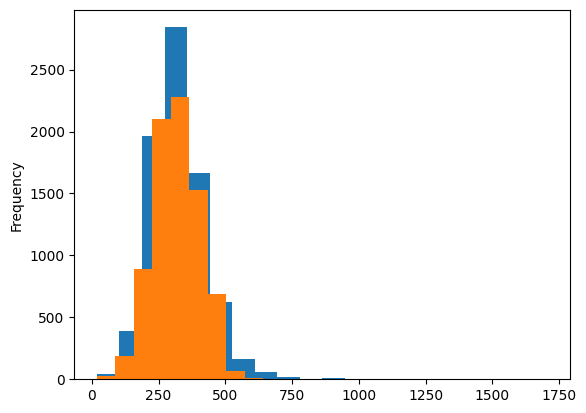

In [135]:
# Create a new data frame with the abstracts and titles
df_analyze = df_base[['title', 'abstract']].copy()
df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)

# Import model for tokenization
model_name  = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer   = AutoTokenizer.from_pretrained(model_name)
embedding_model = SentenceTransformer(model_name)

# Tokenize the abstracts
df_analyze['tokens'] = df_analyze['specter'].apply(lambda x: tokenizer.encode(x))

# Plot the number of  tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))
df_analyze['token_length'].plot(kind='hist', bins=20)
print('Abstracts that exceeds 512 tokens:', len(df_analyze[df_analyze['token_length']>=512]))

# Clear stop words from abstract higher than 512 tokens
# Impor spacy library
nlp = spacy.load('en_core_web_sm')
def clear_stop_words(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Clear stop words from abstracts
df_analyze['abstract_no_stop'] = df_analyze.apply(
    lambda x: clear_stop_words(x['abstract']) if x['token_length']>=512 else x['abstract'],
    axis=1)

# Tokenize the abstracts
df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract_no_stop'], axis=1)
df_analyze['tokens'] = df_analyze['specter'].apply(lambda x: tokenizer.encode(x))

# Plot the number of  tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))
df_analyze['token_length'].plot(kind='hist', bins=20)
print('Abstracts that exceeds 512 tokens:', len(df_analyze[df_analyze['token_length']>=512]))

In [56]:
# Embedding model
embedding_model = SentenceTransformer("allenai-specter", device='cuda')

# Create embedding of abstracts
df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)
abstracts = df_analyze['specter']
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/244 [00:00<?, ?it/s]

In [111]:
# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')

# Create embedding of abstracts
#df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)
abstracts = df_analyze['abstract']
embeddings_mini = embedding_model.encode(abstracts, show_progress_bar=True)

Batches:   0%|          | 0/244 [00:00<?, ?it/s]

In [153]:
def rescale(x, inplace=False):
    """ Rescale an embedding so optimization will not have convergence issues.
    """
    if not inplace:
        x = np.array(x, copy=True)

    x /= np.std(x[:, 0]) * 10000

    return x

# Define BERTopic model function

def BERTopic_model(docs, embeddings, n_comp=20, n_neigh=25, minS_cluster=5,embedding_model='all-MiniLM-L6-v2'):
  # Initialize and rescale PCA embeddings
  pca_embeddings = rescale(PCA(n_components=n_comp).fit_transform(embeddings))

  # Embedding model
  embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
                                        
  # Reduce dimensionality
  umap_model      = umap.UMAP(n_neighbors=n_neigh, 
                              n_components=n_comp, 
                              metric='cosine',
                              random_state=42,
                              init=pca_embeddings,
                              )

  # Cluster the reduced data
  hdbscan_model   = hdbscan.HDBSCAN(min_cluster_size=minS_cluster, 
                                      metric='euclidean', 
                                      cluster_selection_method='eom',
                                      prediction_data = True)

  # Vectorizer
  vectorizer_model = CountVectorizer(stop_words="english",
                                      ngram_range=(1, 2),
                                      min_df=10)

  # Topic representation
  ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

  # Representation model
  representation_model = KeyBERTInspired()
  #representation_model = MaximalMarginalRelevance(diversity=0.3)

  # All steps together
  topic_model = BERTopic(
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
    representation_model=representation_model,# Step 6 - (Optional) Fine-tune topic representations
    calculate_probabilities=True
  )

  # Fit the BERTopic model
  topics, probs = topic_model.fit_transform(docs,  embeddings)

  return topics, probs, topic_model

# Function to calculate silhouette score

def silhouette_score_calc(embeddings, topics):
  # Print the silhouette score
  non_noise_indices   = [i for i, topic in enumerate(topics) if topic != -1]
  filtered_embeddings = embeddings[non_noise_indices]
  filtered_topics     = [topics[i] for i in non_noise_indices]

  silhouette_vals     = silhouette_samples(filtered_embeddings, filtered_topics)
  silhouette_avg      = silhouette_score(filtered_embeddings, filtered_topics)

  # Create a DataFrame to hold the results
  results = pd.DataFrame({'topic': filtered_topics, 'silhouette_score': silhouette_vals})

  # Group by topic and calculate the average Silhouette score per topic
  avg_silhouette_per_topic = results.groupby('topic')['silhouette_score'].mean().reset_index()

  # Count how many topics are negative
  negative_topics = avg_silhouette_per_topic[avg_silhouette_per_topic['silhouette_score'] < 0].shape[0]

  return silhouette_avg, negative_topics

In [156]:
# Embeddings to use
embedings_x = embeddings_mini

n_comp_matrix = [10, 20]
n_neigh_matrix = [100]

results = []

for i in n_comp_matrix:
    for j in n_neigh_matrix:
        topics, probs, topic_model = BERTopic_model(
                                        abstracts,
                                        embedings_x, 
                                        n_comp        = i, 
                                        n_neigh       = j, 
                                        minS_cluster  = 15,
                                        embedding_model='all-MiniLM-L6-v2'
                                        )
        
        silhouette_avg, negative_topics = silhouette_score_calc(embedings_x, topics)

        # Count how many docs are topic == -1
        noise_docs = len([topic for topic in topics if topic == -1])

        # Store the results
        results.append({
            'n_components': i,
            'n_neighbors': j,
            'silhouette_score': silhouette_avg,
            'negative_topics': negative_topics,
            'noise_docs': noise_docs
        })

# Create a DataFrame with the results
results_df2 = pd.DataFrame(results)
print(results_df2)


   n_components  n_neighbors  silhouette_score  negative_topics  noise_docs
0            10          100          0.061119                0        4016
1            20          100          0.042269                1        3730


In [142]:
n_comp_matrix = [10]
n_neigh_matrix = [15, 20, 25]
results = []
for i in n_comp_matrix:
    for j in n_neigh_matrix:
        topics, probs, silhouette_avg, negative_topics = BERTopic_model(
                                                            abstracts,
                                                            embeddings_mini, 
                                                            n_comp        = i, 
                                                            n_neigh       = j, 
                                                            minS_cluster  = 10,
                                                            embedding_model='all-MiniLM-L6-v2'
                                                            )
        # Store the results
        results.append({
            'n_components': i,
            'n_neighbors': j,
            'silhouette_score': silhouette_avg,
            'negative_topics': negative_topics
        })

# Create a DataFrame with the results
results_df_1 = pd.DataFrame(results)
print(results_df_1)

# Best results with n_comp = 10 and n_neigh = 100

   n_components  n_neighbors  silhouette_score  negative_topics
0            10           15          0.037713                5
1            10           20          0.047958                2
2            10           25          0.037949                4


In [148]:
n_comp_matrix = [20]
n_neigh_matrix = [30, 50, 100, 150]
results = []
for i in n_comp_matrix:
    for j in n_neigh_matrix:
        topics, probs, silhouette_avg, negative_topics, topic_model = BERTopic_model(
                                                            abstracts,
                                                            embeddings_mini, 
                                                            n_comp        = i, 
                                                            n_neigh       = j, 
                                                            minS_cluster  = 10,
                                                            embedding_model='all-MiniLM-L6-v2'
                                                            )
        # Store the results
        results.append({
            'n_components': i,
            'n_neighbors': j,
            'silhouette_score': silhouette_avg,
            'negative_topics': negative_topics
        })

# Create a DataFrame with the results
results_df_1 = pd.DataFrame(results)
print(results_df_1)


   n_components  n_neighbors  silhouette_score  negative_topics
0            20           30          0.044404                3
1            20           50          0.046837                3
2            20          100          0.059793                0
3            20          150          0.050088                2


In [157]:
topics, probs, topic_model = BERTopic_model(
                                abstracts,
                                embedings_x, 
                                n_comp        = 10, 
                                n_neigh       = 100, 
                                minS_cluster  = 10,
                                embedding_model='all-MiniLM-L6-v2'
                                )
# We reduce our embeddings to 2D as it will allows us to quickly iterate later on
reduced_embeddings = umap.UMAP(n_neighbors=100, n_components=2, 
                          min_dist=0.0, metric='cosine').fit_transform(embedings_x)

check = topic_model.get_document_info(abstracts)

topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)


In [159]:
topic_model.visualize_hierarchy()

In [107]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities=probs, 
                             threshold=0.05, strategy="probabilities")
topic_model.update_topics(abstracts, topics=new_topics)
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

2024-08-21 16:07:01,830 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [108]:
check = topic_model.get_document_info(abstracts)


In [158]:
topic_model.visualize_term_rank()

In [86]:
topic_model.visualize_documents(abstracts, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)

In [115]:
topic_model.visualize_hierarchy()

In [25]:
topic_model.visualize_hierarchy()

In [141]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3877,-1_hydrogen production_renewable energy_renewa...,"[hydrogen production, renewable energy, renewa...",[This study aims to evaluate and compare two i...
1,0,501,0_electrochemical_electrolyte_catalysts_h2o2,"[electrochemical, electrolyte, catalysts, h2o2...",[The rational design of non-precious-metal bif...
2,1,380,1_energy exergy efficiencies_energy efficiency...,"[energy exergy efficiencies, energy efficiency...",[study aims recover waste heat previously intr...
3,2,237,2_solar hydrogen_hydrogen generation_solar ene...,"[solar hydrogen, hydrogen generation, solar en...",[photocatalytic reduction water hydrogen ( H2 ...
4,3,199,3_renewable energy_cost hydrogen_hydrogen pric...,"[renewable energy, cost hydrogen, hydrogen pri...",[The production of green hydrogen is a key fac...
5,4,198,4_fuel cell vehicles_greenhouse gas emissions_...,"[fuel cell vehicles, greenhouse gas emissions,...",[Transport-related activities represented 34% ...
6,5,189,5_methanol production_hydrogen methanol_co2 em...,"[methanol production, hydrogen methanol, co2 e...",[In this study an internal carbon loop strateg...
7,6,137,6_plants_salt_oxidative_plant,"[plants, salt, oxidative, plant, acid, biochem...",[Global climate change enhances the effect of ...
8,7,134,7_anaerobic digestion_biogas production_biogas...,"[anaerobic digestion, biogas production, bioga...",[anaerobic digestion ( AD ) employed degradati...
9,8,132,8_wastewater treatment_wastewater_oxidation_sl...,"[wastewater treatment, wastewater, oxidation, ...","[Biological treatments, such as activated slud..."


In [37]:
topic_model.visualize_topics()

In [38]:
topic_model.visualize_heatmap()

In [39]:
topic_model.visualize_hierarchy()

In [30]:
topic_model.visualize_barchart(top_n_topics=10, height=200)

## Other revision

Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors


Number of tokens higher than 512: 17


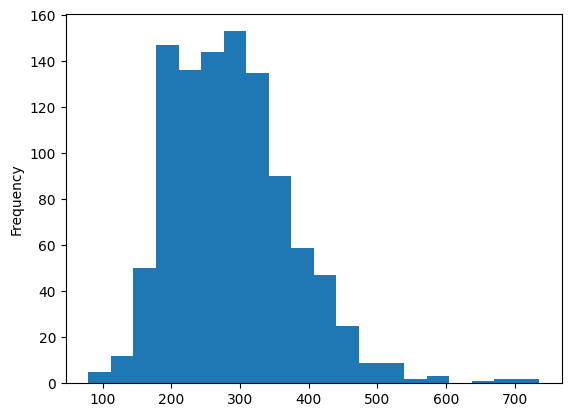

In [40]:
# Create a new data frame with the abstracts and titles
df_analyze2 = df_base[['title', 'abstract']].copy()

# Import model
model_name  = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = SentenceTransformer(model_name)

# Tokenize the abstracts
df_analyze['tokens'] = df_analyze['abstract'].apply(lambda x: tokenizer.encode(x))

# Plot the length of the tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))
df_analyze['token_length'].plot(kind='hist', bins=20)
print('Number of tokens higher than 512:', len(df_analyze[df_analyze['token_length']>512]))


In [50]:
#df_analyze['tokens'] = df_analyze['abstract'].apply(lambda x: tokenizer(x, truncation=True, padding=True, max_length=512, return_tensors='pt'))

# Check if there arer acronyms in the abstracts
def find_acronyms(text):
    return re.findall(r'\b[A-Z]{2,}\b', text)

df_analyze['acronyms'] = df_analyze['abstract'].apply(find_acronyms)

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]
acronyms_count = Counter(acronyms)
acronyms_count = pd.DataFrame(acronyms_count.items(), columns=['acronym', 'count'])



In [70]:
# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Reduce dimensionality
umap_model      = umap.UMAP(n_neighbors=25, 
                            n_components=10, 
                            metric='cosine')

# Cluster the reduced data
hdbscan_model   = hdbscan.HDBSCAN(min_cluster_size=10, 
                                    metric='euclidean', 
                                    cluster_selection_method='eom',
                                    prediction_data = True)

# Vectorizer
vectorizer_model = CountVectorizer(stop_words="english",
                                    ngram_range=(1, 3),
                                    min_df=10)

# Topic representation
ctfidf_model = ClassTfidfTransformer()

# Representation model
representation_model = MaximalMarginalRelevance(diversity=0.3)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
)

abstracts = df_analyze['abstract']
embeddings = embedding_model.encode(abstracts, convert_to_tensor=True).cpu().numpy()


topics, probs = topic_model.fit_transform(abstracts, embeddings)
topic_model.visualize_topics()

In [71]:
check = topic_model.get_document_info(abstracts)

In [72]:
topic_model.visualize_barchart(top_n_topics=10, height=200)

In [69]:

# Load your data
abstracts = df_analyze['abstract']

# Print the number of documents
print(f"Number of documents: {len(abstracts)}")

# Define the range of parameters to explore
n_neighbors_range = [5, 10, 15, 25, 50]
n_components_range = [5, 10, 15, 20]

# Store the results
results = []

# Load the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for the abstracts
embeddings = embedding_model.encode(abstracts, convert_to_tensor=True).cpu().numpy()

for n_neighbors in n_neighbors_range:
    for n_components in n_components_range:
        try:
            # Step 2 - Reduce dimensionality with UMAP
            umap_model = umap.UMAP(n_neighbors=n_neighbors, 
                                   n_components=n_components, 
                                   metric='cosine')

            # Step 3 - Cluster reduced embeddings with HDBSCAN
            hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, 
                                            metric='euclidean', 
                                            cluster_selection_method='eom',
                                            prediction_data=True)
            
            # Step 4 - Tokenize topics with CountVectorizer
            vectorizer_model = CountVectorizer(stop_words="english",
                                               ngram_range=(1, 3),
                                               min_df=10)   # Adjust min_df
                                               #, max_df=0.95) # Adjust max_df

            # Check the intermediate values
            print(f"Using min_df={vectorizer_model.min_df} and max_df={vectorizer_model.max_df}")

            # Check the actual number of documents
            print(f"Number of documents for vectorization: {len(abstracts)}")

            # Create BERTopic model
            topic_model = BERTopic(
                embedding_model=embedding_model,
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                vectorizer_model=vectorizer_model,
                ctfidf_model=ClassTfidfTransformer(),
                representation_model=MaximalMarginalRelevance(diversity=0.3)
            )
            
            # Fit the model
            topics, probs = topic_model.fit_transform(abstracts, embeddings)
            
            # Obtain the UMAP-reduced embeddings from the model
            umap_embeddings = topic_model.umap_model.embedding_

            # Check UMAP embeddings shape
            print(f"UMAP embeddings shape: {umap_embeddings.shape}")

            # Calculate the silhouette score
            score = silhouette_score(umap_embeddings, topics)
            
            # Store the results
            results.append({
                'n_neighbors': n_neighbors,
                'n_components': n_components,
                'silhouette_score': score
            })

        except ValueError as e:
            print(f"ValueError occurred with n_neighbors={n_neighbors} and n_components={n_components}: {e}")

        except Exception as e:
            print(f"An unexpected error occurred with n_neighbors={n_neighbors} and n_components={n_components}: {e}")

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Find the best combination
if not df_results.empty:
    best_result = df_results.loc[df_results['silhouette_score'].idxmax()]
    print("Best n_neighbors:", best_result['n_neighbors'])
    print("Best n_components:", best_result['n_components'])
    print("Best silhouette score:", best_result['silhouette_score'])
else:
    print("No valid results were generated.")

Number of documents: 1031
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 1031
ValueError occurred with n_neighbors=5 and n_components=5: max_df corresponds to < documents than min_df
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 1031
ValueError occurred with n_neighbors=5 and n_components=10: max_df corresponds to < documents than min_df
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 1031
ValueError occurred with n_neighbors=5 and n_components=15: max_df corresponds to < documents than min_df
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 1031
ValueError occurred with n_neighbors=5 and n_components=20: max_df corresponds to < documents than min_df
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 1031
ValueError occurred with n_neighbors=10 and n_components=5: max_df corresponds to < documents than min_df
Using min_df=10 and max_df=1.0
Number of documents for vectorization: 

## Other type

Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors


<Axes: ylabel='Frequency'>

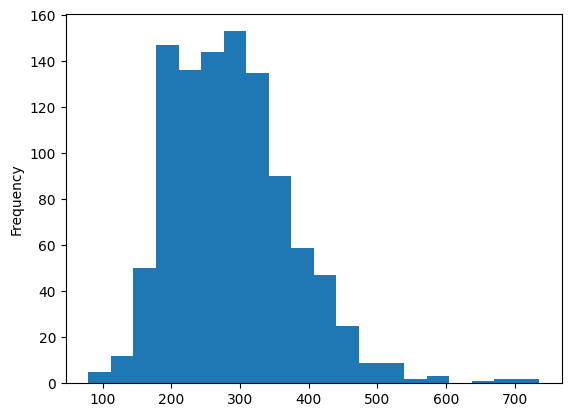

In [20]:
# Create a new data frame with the abstracts and titles
df_analyze2 = df_base[['title', 'abstract']].copy()

# Import model
model_name  = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = SentenceTransformer(model_name)

# Tokenize the abstracts
df_analyze['tokens'] = df_analyze['abstract'].apply(lambda x: tokenizer.encode(x))

# Plot the length of the tokens and check how many are higher than 512
df_analyze['token_length'] = df_analyze['tokens'].apply(lambda x: len(x))
df_analyze['token_length'].plot(kind='hist', bins=20)

In [30]:
# Remove stop words spacy
def preprocess_text(doc):
    doc = nlp(doc)
    tokens = [token.text.lower() for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Check if there arer acronyms in the abstracts
def find_acronyms(text):
    return re.findall(r'\b[A-Z]{2,}\b', text)

df_analyze['acronyms'] = df_analyze['abstract'].apply(find_acronyms)

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]

# Count the number of acronyms
acronyms = [acronym for sublist in df_analyze['acronyms'].tolist() for acronym in sublist]
acronyms_count = Counter(acronyms)
acronyms_count = pd.DataFrame(acronyms_count.items(), columns=['acronym', 'count'])

In [108]:
# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Reduce dimensionality
umap_model      = umap.UMAP(n_neighbors=25, 
                            n_components=20, 
                            metric='cosine',
                            random_state=42)

# Cluster the reduced data
hdbscan_model   = hdbscan.HDBSCAN(min_cluster_size=5, 
                                    metric='euclidean', 
                                    cluster_selection_method='eom',
                                    prediction_data = True)

# Vectorizer
vectorizer_model = CountVectorizer(stop_words="english",
                                    ngram_range=(1, 2),
                                    min_df=2)

# Representation model
keybert_model=KeyBERTInspired()
pos_model=PartOfSpeech('en_core_web_sm')
mmr_model=MaximalMarginalRelevance(diversity=0.3)

representation_model={
    'KeyBERT':keybert_model,
    'MMR':mmr_model,
    'POS':pos_model
}

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
)

abstracts = df_analyze['abstract']

#df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)
#abstracts = df_analyze['specter']

topics, probs = topic_model.fit_transform(abstracts, embeddings)
topic_model.visualize_topics()

In [114]:
# Embedding model
embedding_model = SentenceTransformer('allenai-specter')

# Reduce dimensionality
umap_model      = umap.UMAP(n_neighbors=25, 
                            n_components=20, 
                            metric='cosine',
                            random_state=42)

# Cluster the reduced data
hdbscan_model   = hdbscan.HDBSCAN(min_cluster_size=5, 
                                    metric='euclidean', 
                                    cluster_selection_method='eom',
                                    prediction_data = True)

# Vectorizer
vectorizer_model = CountVectorizer(stop_words="english",
                                    ngram_range=(1, 3),
                                    min_df=2)

# Representation model
keybert_model=KeyBERTInspired()
pos_model=PartOfSpeech('en_core_web_sm')
mmr_model=MaximalMarginalRelevance(diversity=0.3)

representation_model={
    'KeyBERT':keybert_model,
    'MMR':mmr_model,
    'POS':pos_model
}

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
)

#abstracts = df_analyze['abstract']

df_analyze['specter'] = df_analyze.apply(lambda x: x['title']+'[SEP]'+x['abstract'], axis=1)
abstracts = df_analyze['specter']

topics, probs = topic_model.fit_transform(abstracts, embeddings)
topic_model.visualize_topics()

In [115]:
topic_model.visualize_barchart(top_n_topics=10, height=200, width=200)

In [125]:
check = topic_model.get_document_info(abstracts)

In [126]:
topic_model.visualize_hierarchy()

In [109]:
topic_model.visualize_hierarchy()

In [124]:
# Reduce outliers
new_topics=topic_model.reduce_outliers(abstracts, topics)
topic_model.update_topics(abstracts, topics=new_topics)

2024-08-20 20:09:22,992 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [120]:
topic_distr, _ =topic_model.approximate_distribution(abstracts, window=8, stride=4)

In [121]:
abstract_id=265
print(abstracts[abstract_id])

Technology roadmap for hydrogen-fuelled transportation in the UK[SEP]Transportation is the sector responsible for the largest greenhouse gas emission in the UK. To mitigate its impact on the environment and move towards net-zero emissions by 2050, hydrogen-fuelled transportation has been explored through research and development as well as trials. This article presents an overview of relevant technologies and issues that challenge the supply, use and marketability of hydrogen for transportation application in the UK, covering on-road, aviation, maritime and rail transportation modes. The current development statutes of the different transportation modes were reviewed and compared, highlighting similarities and differences in fuel cells, internal combustion engines, storage technologies, supply chains and refuelling characteristics. In addition, common and specific future research needs in the short to long term for the different transportation modes were suggested. The findings showed 

In [122]:
topic_model.visualize_distribution(topic_distr[abstract_id])